# Segundo ejercicio de clústering. ¿Por qué no?
Como veíamos en el primer proyecto de este reto, el *clustering* es una técnica de *machine learning* que nos permite crear grupos. Se le considera aprendizaje no supervisado debido a que no hay etiquetas conocidas.
## Importación de las librerías necesarias
Necesitamos importar herramientas de `skleanr` como `KMeans`(algoritmo de *clusters*) y `StandardScaler` (para normalizar los datos). Éste último es una herramienta de preprocesamiento que normaliza los datos (0 como media y desviación estándar 1).

In [1]:
# Manipulación y creación de datos
import numpy as np
import pandas as pd

# Preprocesamiento y clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns


## Crear el DataFrame con datos aleatorios

La primera línea de código `np.random.seed(42)` es una semilla aleatoria que nos permite resultados aleatorios pero reproducibles. Afecta a todas las creaciones de valores aleatorios posteriores. Estamos fijando la semilla, así como en el primer proyecto. Así tendremos resultados reproducibles. 

Después generamos valores aleatorios con ciertas distribuciones y reglas con los métodos `np.random.normal` y `np.random.poisson` y sus atributos.

In [2]:
# Fijamos una semilla para reproducibilidad
np.random.seed(42)

# Crear el DataFrame con 1000 usuarios y 5 características
clientes = pd.DataFrame({
    "horas_escucha_dia": np.random.normal(loc=2, scale=1, size=1000).clip(0, None), # Distribución normal.
    "canciones_distintas": np.random.normal(loc=40, scale=15, size=1000).clip(0, None),
    "likes_semana": np.random.poisson(lam=5, size=1000),
    "playlists_creadas": np.random.poisson(lam=2, size=1000),
    "skips_por_dia": np.random.normal(loc=10, scale=4, size=1000).clip(0, None)
})

# Ver los primeros registros
clientes.head()


,horas_escucha_dia,canciones_distintas,likes_semana,playlists_creadas,skips_por_dia
0,2.496714,60.990332,3,2,15.966695
1,1.861736,53.869505,6,0,12.899317
2,2.647689,40.894456,4,1,13.691910
3,3.523030,30.295948,4,1,7.917478
4,1.765847,50.473350,8,2,3.609521


## Normalizar los datos
`KMeans` es sensible a las escalas (porque está basado en distancia), así que normalizamos con `StandardScaler()`. Normalizar significa ajustar los datos para que todas las variables tengan la misma importancia numérica. Así todas las variables estarán en la misma escala.

In [3]:
# Instanciar el escalador
scaler = StandardScaler()

# Aplicar al dataset (sin incluir aún la columna cluster)
datos_escalados = scaler.fit_transform(clientes)


## Aplicar KMeans (clustering)
Usaremos 3 clusters. Esto crea una instancia del modelo `KMeans` de `scikit-learn`. Estamos creando el modelo.

Después entrenamos el modelo (`fit`) con los datos escalados. Así se predice el grupo al que pertenece cada dato. 

`kmeans.fit_predict(...)` aprende los patrones y encuentra los centroides de los *clusters*.

Finalmente añadimos los *clusters* a la tabla.

In [7]:
# Crear y entrenar el modelo KMeans. Seleccionamos tres 'clusters' y cuántas veces se va a correr el algoritmo KMeans.
# Más repeticiones, mayor probabilidad de encontrar un buen agrupamiento. 
# Determinamos una semilla aleatoria.
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Ajustar el modelo y predecir el cluster de cada usuario
clientes["cluster"] = kmeans.fit_predict(datos_escalados)

# Ver los primeros con su grupo asignado
clientes.head()

# Métrica aprendida después de desarrollar este ejercicio originalmente.
print('Silhouette_score: {:.2f}'.format(silhouette_score(datos_escalados, clientes['cluster'])))


Silhouette_score: 0.14


## Analizar los clusters
Agrupar por `cluster` y ver el comportamiento promedio de cada una de las características a excepción de `'cluster'`. Los datos están truncados en el segundo decimal para hacerlos más legibles.

In [8]:
# Promedio de cada característica por grupo
resumen = clientes.groupby("cluster").mean().round(2)

# Mostrar resumen
print(resumen)


         horas_escucha_dia  canciones_distintas  likes_semana  \
cluster                                                         
0                     2.81                30.36          4.52   
1                     1.64                45.37          6.75   
2                     1.65                46.98          3.72   

         playlists_creadas  skips_por_dia  
cluster                                    
0                     1.99           9.21  
1                     2.51           7.97  
2                     1.61          12.39  


## Visualizar los grupos con pares de variables
`pairplot()` es una función de `seaborn` que muestra gráficos de dispersión para cada par de variables. Así podemos comenzar a relaizar hipótesis y notar correlaciones.

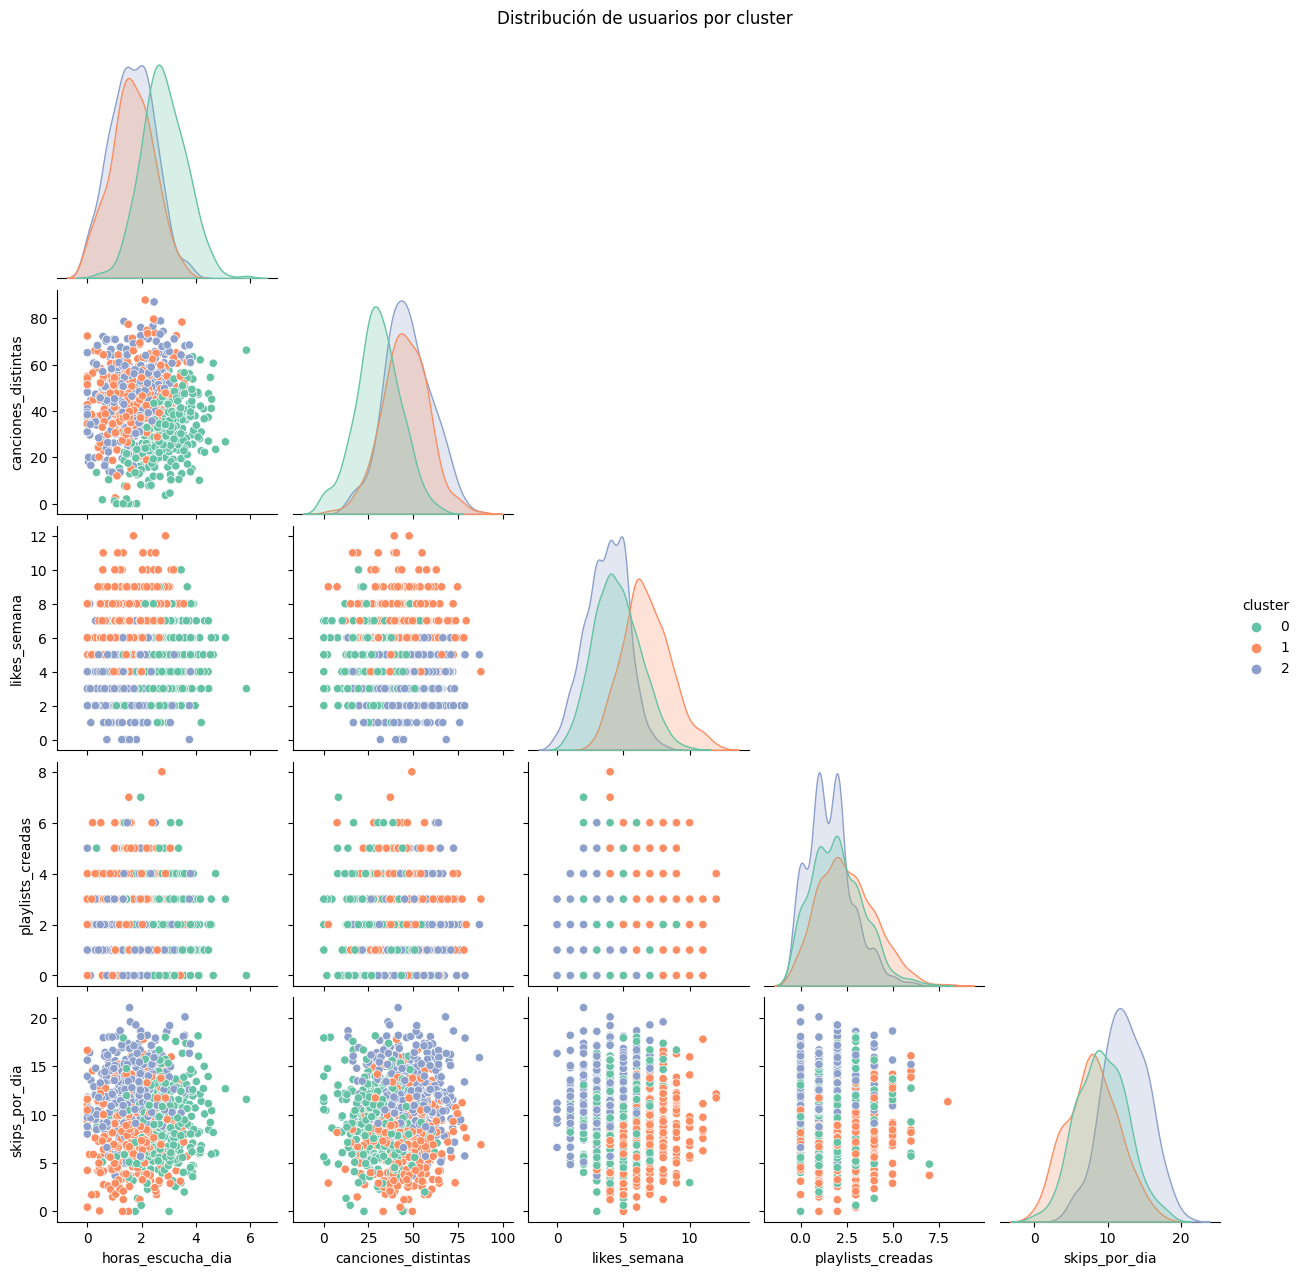

In [9]:
# Usamos seaborn para ver la separación entre clusters
sns.pairplot(clientes, hue="cluster", corner=True, palette="Set2")
plt.suptitle("Distribución de usuarios por cluster", y=1.02)
plt.show()

## Explicación de las gráficas

- Cada fila es un usuario.

- Cada columna es una característica de comportamiento.

- KMeans agrupó a los usuarios en 3 grupos distintos, basados en patrones comunes.

- Al observar el resumen y el gráfico, puedes interpretar qué define a cada grupo.

## Conclusión de los datos
El cluster 0 tiene valores más grandes en horas de escucha al día. Creo que esta variable es importante en un caso como el nuestro, donde analizamos una aplicación musical de streaming. Creo que los usuarios con más uso promedio diario son más leales y menos propensos a abandonar la suscripción. 

Pero curiosamente ese cluster es el que tiene un menor número de canciones distintas. ¿Será que son pacientes y casi no hacen skip?

Además veo que el cluster 1 tiene muchos likes por semana. Ese dato también se me hace importante. Si te gustan las canciones y las guardas con likes, seguro vuelvas después a la aplicación. 

Finalmente el cluster 2 tiene muchos skips, un número bajo de likes, un alto número de canciones distintas y un bajo valor de horas de escucha al día. Pareciera que si bien son usuarios que usan la app, son más dispersos y se aburren. Curiosamente su número de playlist creadas es alto.

Si bien habrá características con valores contradictorios porque generamos datos aleatorios, creo que el cluster 0 es el más fiel. Los clusters 1 y 2 me parecen clusters de usuarios más dispersos que podrían ser más propensos a dejar la app o disminuir su tiempo de horas diarias. 

## Conclusión final
El análisis de clusters no solo agrupa datos, sino que descubre patrones y nos ayuda a tomar decisiones estratégicas sobre usuarios, productos y experiencias.